In [1]:
from data.dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


from models.lstm import Generator, Discriminator


class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('./data/compiled/inputs.csv')
        self.batch_size = 32
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        
        self.ngpu = 1
        
        # Train params
        self.lr = 0.0002
        self.epochs = 500
        
opts = Options()

# Setup Dataset

In [2]:
dataset = MULTI_VP_Dataset(opts.data_path)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=opts.shuffle, 
                        num_workers=opts.nworkers, drop_last=opts.drop_last)

Inputs shape: torch.Size([11771, 3, 640])
Inputs head:
 tensor([[[0.0000, 0.5062, 0.5006,  ..., 0.6082, 0.6109, 0.6116],
         [0.9519, 0.9520, 0.9526,  ..., 0.9426, 0.9429, 0.9437],
         [0.3290, 0.3303, 0.3313,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.6257, 0.6233,  ..., 0.7078, 0.7110, 0.7107],
         [0.9542, 0.9542, 0.9546,  ..., 0.9556, 0.9561, 0.9568],
         [0.4024, 0.4034, 0.4061,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.7348, 0.7330,  ..., 0.6912, 0.6941, 0.6934],
         [0.9593, 0.9594, 0.9592,  ..., 0.9572, 0.9575, 0.9583],
         [0.4684, 0.4685, 0.4726,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.3933, 0.3870,  ..., 0.6674, 0.6708, 0.6707],
         [0.9507, 0.9509, 0.9514,  ..., 0.9605, 0.9609, 0.9619],
         [0.2569, 0.2568, 0.2582,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.6378, 0.6346,  ..., 0.6534, 0.6565, 0.6573],
         [0.9573, 0.9575, 0.9574,  ..., 0.9558, 0.9563, 0.9570],
         [0.4084, 0.4101, 

# Models

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda:0


In [4]:
dataset.inputs.shape

torch.Size([11771, 3, 640])

In [5]:
netG = Generator(
    input_size=dataset.inputs.shape[2],
    hidden_size=32,
    output_size=dataset.inputs.shape[2],
    device=device
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[2],
    hidden_size=100,
    device=device
).to(device)

print(netG, netD)

Generator(
  (lstm0): LSTM(640, 32, batch_first=True)
  (lstm1): LSTM(32, 64, batch_first=True)
  (lstm2): LSTM(64, 128, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=640, bias=True)
    (1): Tanh()
  )
) Discriminator(
  (lstm): LSTM(640, 100, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


# Training

In [6]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
# fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.lr)

seq_len = dataset.inputs.shape[1]


In [7]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    # For each batch in the dataloader
    for i, (x, _filename) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real = x.to(device)
        
        b_size = real.size(0)
        label = torch.full((b_size, seq_len, 1), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output, _ = netD(real)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn_like(real, device=device)
        # noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake batch with G
        fake, _ = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output, _ = netD(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output, _ = netD(fake)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, opts.epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == opts.epochs-1) and (i == len(dataloader)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/500][0/368]	Loss_D: 1.3567	Loss_G: 0.6632	D(x): 0.5319	D(G(z)): 0.5158 / 0.5152
[0/500][50/368]	Loss_D: 0.8915	Loss_G: 0.6008	D(x): 0.9308	D(G(z)): 0.5550 / 0.5497
[0/500][100/368]	Loss_D: 0.7891	Loss_G: 0.8281	D(x): 0.8631	D(G(z)): 0.4683 / 0.4387
[0/500][150/368]	Loss_D: 0.6816	Loss_G: 0.9560	D(x): 0.8855	D(G(z)): 0.4133 / 0.3981
[0/500][200/368]	Loss_D: 0.5421	Loss_G: 0.9829	D(x): 0.9568	D(G(z)): 0.3864 / 0.3797
[0/500][250/368]	Loss_D: 0.4709	Loss_G: 1.1363	D(x): 0.9526	D(G(z)): 0.3339 / 0.3286
[0/500][300/368]	Loss_D: 0.5164	Loss_G: 1.0062	D(x): 0.9679	D(G(z)): 0.3785 / 0.3702
[0/500][350/368]	Loss_D: 0.4107	Loss_G: 1.2221	D(x): 0.9772	D(G(z)): 0.3130 / 0.3062
[1/500][0/368]	Loss_D: 0.3905	Loss_G: 1.2233	D(x): 0.9869	D(G(z)): 0.3084 / 0.3027
[1/500][50/368]	Loss_D: 0.4316	Loss_G: 1.1078	D(x): 0.9876	D(G(z)): 0.3411 / 0.3318
[1/500][100/368]	Loss_D: 0.2846	Loss_G: 1.7287	D(x): 0.9705	D(G(z)): 0.2150 / 0.2090
[1/500][150/368]	Loss_D: 0.5388	Loss_G: 1.158

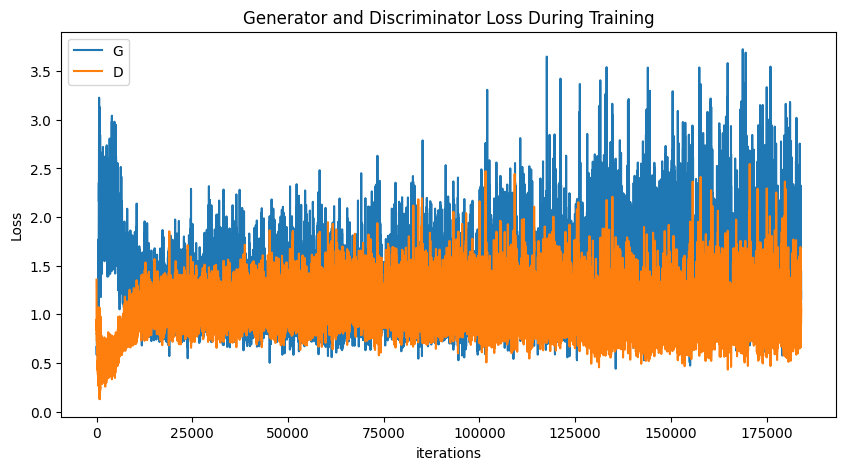

In [8]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
noise = torch.randn_like(real, device=device)
fake, _ = netG(noise)
fake

tensor([[[-0.1272,  0.4128,  0.4870,  ...,  0.3436,  0.3222,  0.1823],
         [ 0.3697,  0.3340,  0.4606,  ...,  0.5650,  0.4634,  0.3830],
         [ 0.4545,  0.5599,  0.6578,  ..., -0.0699,  0.0581, -0.0088]],

        [[-0.1440,  0.4233,  0.5202,  ...,  0.4916,  0.4857,  0.3532],
         [ 0.1290,  0.0616,  0.1705,  ...,  0.2949,  0.2847,  0.1793],
         [ 0.6289,  0.7859,  0.8260,  ..., -0.1019,  0.0590,  0.0587]],

        [[-0.0175,  0.6771,  0.7102,  ...,  0.4806,  0.4360,  0.2975],
         [ 0.6671,  0.7126,  0.7950,  ...,  0.7800,  0.6063,  0.6323],
         [ 0.4169,  0.4003,  0.6320,  ..., -0.0065, -0.0120, -0.0478]],

        ...,

        [[-0.0624, -0.0759,  0.1401,  ...,  0.1104,  0.2328,  0.1582],
         [ 0.6234,  0.6836,  0.3611,  ...,  0.4582,  0.8307,  0.6485],
         [ 0.1805,  0.3190,  0.3576,  ..., -0.0506, -0.0190, -0.1370]],

        [[-0.0966,  0.7879,  0.8535,  ...,  0.7277,  0.6383,  0.5961],
         [ 0.6973,  0.8710,  0.9138,  ...,  0.8933,  0.